### Notebook to plot PICCOLO SEAPOL overpass data.

James Ruppert  
jruppert@ou.edu  
9/15/24

### Main settings

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
import subprocess
import xarray as xr
import cmocean

In [223]:
main = "/Users/jamesruppert/code/PICCOLO/seapol/"

# Get file list
def gridded_filelist():
    process = subprocess.Popen(['ls --color=none '+main+'*/gridded/*nc'],shell=True,
        stdout=subprocess.PIPE,universal_newlines=True)
    files = process.stdout.readlines()
    return files

files = gridded_filelist()
files
file_read=files[-2]
# print(file_read)
# print(files)

### Read scan

In [224]:
# Error handling function
# 
# From Michael:
#   FillValue = -32768 is where the radar did not scan
#   missing_value = -9999 is where data has been removed by QC
# 
def fill_missing(cfrad_dset, FillValue=-32768, missing_value=-9999):
    index_fill = np.where(cfrad_dset['refl'] == FillValue)
    cfrad_dset['refl'][index_fill] = np.nan
    # index_fill = np.where(cfrad_dset['refl'] == missing_value)
    # cfrad_dset['refl'][index_fill] = np.nan
    return cfrad_dset

# Main read function
def read_cfrad(file):

    cfrad_file = xr.open_dataset(file.rstrip('\n'), engine="netcdf4",
                                 mask_and_scale=False) # Manually control fill/missing values
    cf_timestamp = cfrad_file['time'].data[0]

    ix = np.squeeze(cfrad_file['X'].data)*1e-3 # m --> km
    dx = ix[1]-ix[0]
    x2 = np.append(ix-0.5*dx,ix[-1]+0.5*dx)

    ix = np.squeeze(cfrad_file['Y'].data)*1e-3 # m --> km
    dx = ix[1]-ix[0]
    x1 = np.append(ix-0.5*dx,ix[-1]+0.5*dx)

    ix = np.squeeze(cfrad_file['Z'].data)*1e-3 # m --> km
    z = ix

    refl = np.squeeze(cfrad_file['DBZ'].data) # dBZ
    FillValue = cfrad_file['DBZ']._FillValue # -32768 is where the radar did not scan
    missing_value = cfrad_file['DBZ'].missing_value # -9999 is where data has been removed by QC

    cfrad_file.close()

    cfrad_dset = {
        'cf_timestamp': cf_timestamp,
        'x1': x1,
        'x2': x2,
        'z': z,
        'refl': refl,
        'flag_noscan': FillValue,
        'flag_missing': missing_value
    }
    return fill_missing(cfrad_dset, FillValue=FillValue, missing_value=missing_value)
    # return cfrad_dset

### Echo-top height

In [225]:
# Echo-top height
def get_echo_top(cfrad_dset, dbz_threshold=15):
    dims=cfrad_dset['refl'].shape[1:]
    echo_top=np.full(dims, np.nan)
    for ix1 in range(dims[0]):
        for ix2 in range(dims[1]):
    # for ix1 in range(50):
        # for ix2 in range(50):
            ind_finite = np.where(np.isfinite(cfrad_dset['refl'][:,ix1,ix2]))[0]
            if ind_finite.size == 0:
                continue
            ind_meets_thresh = np.where(cfrad_dset['refl'][:,ix1,ix2] > dbz_threshold)[0]
            if ind_meets_thresh.size == 0:
                echo_top[ix1,ix2] = 0
                continue
            echo_top[ix1,ix2] = cfrad_dset['z'][np.max(ind_meets_thresh)]
    return echo_top
cfrad_dset = read_cfrad(files[6])
echo_top = get_echo_top(cfrad_dset)

In [226]:
print(np.nanmax(cfrad_dset['refl']))
print(np.nanmin(cfrad_dset['refl']))

47.163925
-9999.0


In [227]:
print(np.nanmax(echo_top))
print(np.nanmin(echo_top))

11.000000953674316
0.0


---
### Plotting routines

#### Plot functions

In [228]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
figdir = "/Volumes/wiss/M203/SEA-POL/figures/"

In [323]:
def plot_ppi(figdata, zlev=0):

    fig_x = 5
    fig_y = 5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained", ) # row, column

    ax.set_title(figdata['date_str']+', '+str(np.round(figdata['z'][zlev],1))+' km')

    # ax.set_ylim(0,top)
    # ax.set_xlim(figdata['xlim'])
    ax.set_xlim((figdata['x2'][0],figdata['x2'][-1]))
    ax.set_ylim((figdata['x1'][0],figdata['x1'][-1]))
    ax.set_xlabel('Distance [km]')
    ax.set_ylabel('Distance [km]')

    ax.set_aspect('equal', 'box')

    ax.grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    pltvar = figdata['refl'][zlev]

    # Plot valid data area
    valid = np.copy(pltvar)
    valid[np.where(np.isfinite(pltvar))] = 1
    norm=colors.Normalize(0.7,2)
    im = ax.pcolormesh(figdata['x1'], figdata['x2'], valid, cmap='Grays', norm=norm)

    # Mask out where dBZ < -5
    pltvar = np.ma.masked_where(pltvar < -5, pltvar)

    radarcbar = ['PeachPuff', 'Aqua', 'DodgerBlue', 'MediumBlue', 'Lime', \
                'LimeGreen', 'Green', 'Yellow', 'Orange', 'OrangeRed', \
                'Red', 'Crimson', 'Fuchsia', 'Indigo', 'DarkCyan', 'White']
    levels = np.arange(-5, 75, 5)
    # im = ax.contourf(figdata['x1'][:-1], figdata['x2'][:-1], pltvar, colors=radarcbar, levels=levels)

    norm=colors.Normalize(-5, 75, clip=False)
    im = ax.pcolormesh(figdata['x1'], figdata['x2'], pltvar, cmap=cmocean.cm.balance, norm=norm, shading='flat')
    # clevels=np.linspace(-5,75,num=20)
    # im = ax.contourf(figdata['x1'][:-1], figdata['x2'][:-1], pltvar, clevels,
    #                        extend='neither', cmap=cmocean.cm.balance, zorder=1)#, norm=figdata['norm'])
    fig.colorbar(im, ax=ax, label='dBZ', ticks=ticker.AutoLocator(), shrink=0.5)

    date_tag = figdata['date_str'][0:4]+figdata['date_str'][5:7]+figdata['date_str'][8:10]+\
        '_'+figdata['date_str'][11:13]+figdata['date_str'][14:16]
    plt.savefig(figdir+'cappi_ppi_'+date_tag+'.png',dpi=200, facecolor='white', \
            bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()
    return

In [321]:
def plot_echotop(figdata):

    fig_x = 5
    fig_y = 5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained", ) # row, column

    ax.set_title(figdata['date_str'])

    # ax.set_ylim(0,top)
    # ax.set_xlim(figdata['xlim'])
    ax.set_xlim((figdata['x2'][0],figdata['x2'][-1]))
    ax.set_ylim((figdata['x1'][0],figdata['x1'][-1]))
    ax.set_xlabel('Distance [km]')
    ax.set_ylabel('Distance [km]')

    ax.set_aspect('equal', 'box')

    ax.grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    pltvar = figdata['pltvar']

    norm=colors.Normalize(0,15, clip=False)
    im = ax.pcolormesh(figdata['x1'], figdata['x2'], pltvar, cmap=cmocean.cm.rain, norm=norm)
    # clevels=np.linspace(0,18,num=20)
    # im = ax.contourf(figdata['x1'][:-1], figdata['x2'][:-1], pltvar, clevels,
    #                        extend='neither', cmap=cmocean.cm.curl, zorder=1)#, norm=figdata['norm'])
    fig.colorbar(im, ax=ax, label='km', ticks=ticker.AutoLocator(), shrink=0.6)

    date_tag = figdata['date_str'][0:4]+figdata['date_str'][5:7]+figdata['date_str'][8:10]+\
        '_'+figdata['date_str'][11:13]+figdata['date_str'][14:16]
    plt.savefig(figdir+'cappi_echotop_'+date_tag+'.png',dpi=200, facecolor='white', \
            bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()
    return

#### Plots

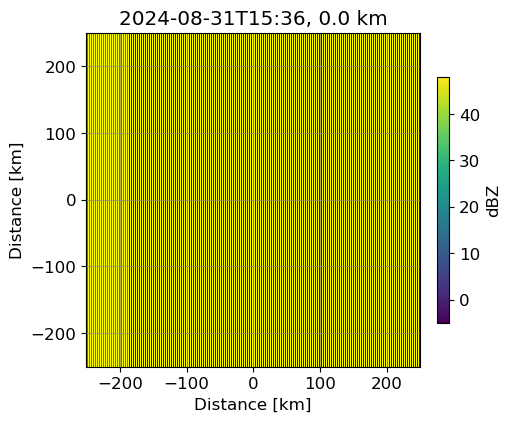

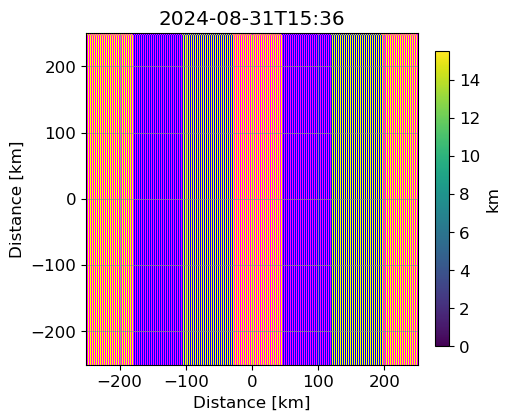

In [324]:
# for ifile in files:
for ifile in files[0:1]:
    cfrad_dset = read_cfrad(ifile)

    # PPIs

    figdata = {
        'x1': cfrad_dset['x1'],
        'x2': cfrad_dset['x2'],
        'z': cfrad_dset['z'],
        'refl': cfrad_dset['refl'],
        'date_str': np.datetime_as_string(cfrad_dset['cf_timestamp'], 'm'),
        # 'xlim': xlim,
            }

    nz = cfrad_dset['z'].size
    # for ilev in range(nz):
    # for ilev in range(3):
    plot_ppi(figdata, zlev=0)


    # Echo-top

    echo_top = get_echo_top(cfrad_dset)

    figdata = {
        'x1': cfrad_dset['x1'],
        'x2': cfrad_dset['x2'],
        'z': cfrad_dset['z'],
        'pltvar': echo_top,
        'date_str': np.datetime_as_string(cfrad_dset['cf_timestamp'], 'm'),
        # 'xlim': xlim,
            }

    plot_echotop(figdata)